# Random Forest 

In [36]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay
from sklearn.cluster import KMeans


In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
file_path = "../data/cleaned_diabetes_health_indicators_dataset.csv"
df = pd.read_csv(file_path)

target_col = 'Diabetes_012'
numerical = ['BMI', 'MentHlth', 'PhysHlth', 'Age']

unique = df.nunique()
already_one_hot, categorical = [], []

check_cols = [col for col in df.columns if col not in numerical + [target_col]]

for col in check_cols:
    if unique[col] == 2:
        already_one_hot.append(col)
    else:
        categorical.append(col)

df = pd.get_dummies(df, columns=categorical, drop_first=True)

print("Already one-hot-encoded columns:", already_one_hot)
print("categorical columns (one-hot applied):", categorical)
print("Numerical columns:", numerical)
print("Target column:", target_col)



Already one-hot-encoded columns: ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
categorical columns (one-hot applied): ['GenHlth', 'Education', 'Income']
Numerical columns: ['BMI', 'MentHlth', 'PhysHlth', 'Age']
Target column: Diabetes_012


In [19]:

X = df.drop('Diabetes_012', axis=1)  
y = df['Diabetes_012']      

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
scaler = StandardScaler()
X_train[numerical] = scaler.fit_transform(X_train[numerical])
X_test[numerical] = scaler.fit_transform(X_test[numerical])


#Lasso Regulization

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

model_cv = LogisticRegressionCV(
    Cs=np.logspace(-3, 2, 30),
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='f1_weighted',
    max_iter=1000,
    refit=True,
    class_weight='balanced'
)

model_cv.fit(X_train, y_train)

best_C = model_cv.C_[0]
print("Best C found by cross-validation:", best_C)


Cs_path = np.logspace(-3, 2, 30)
coefs = []

for C in Cs_path:
    model = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        C=C,
        max_iter=1000,
        class_weight='balanced'
    )
    model.fit(X_train, y_train)
    coefs.append(model.coef_.flatten())

coefs = np.array(coefs)

# 3. Plot the coefficient paths
plt.figure(figsize=(12, 8))

# Plot each coefficient path
for i in range(coefs.shape[1]):
    plt.plot(Cs_path, coefs[:, i ], label=f'{X_train.columns[i]}')

plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Coefficient Value')
plt.title('LASSO (Logistic Regression with L1) Path')

# 4. Mark the best C
plt.axvline(x=best_C, color='black', linestyle='--', label=f'Best C = {best_C:.4f}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

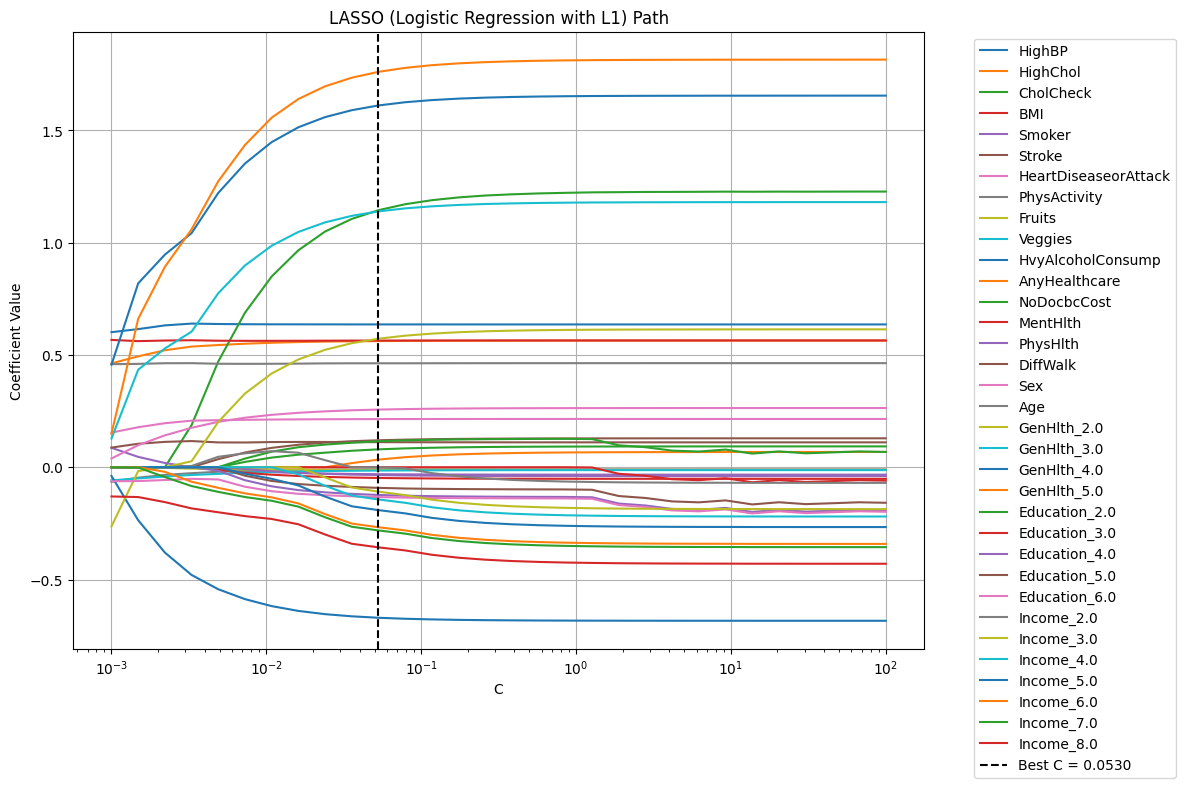

In [ ]:
test_accuracy = model_cv.score(X_test, y_test)
y_pred = model_cv.predict(X_test)
print('Classification Report & Confusion Matrix: Training')
print(classification_report(y_train,model_cv.predict(X_train)))
conf_train = confusion_matrix(y_train,model_cv.predict(X_train))
ConfusionMatrixDisplay(conf_train).plot()

print('Classification Report & Confusion Matrix: Testing')
print(classification_report(y_test, y_pred))
conf_test = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_test).plot()

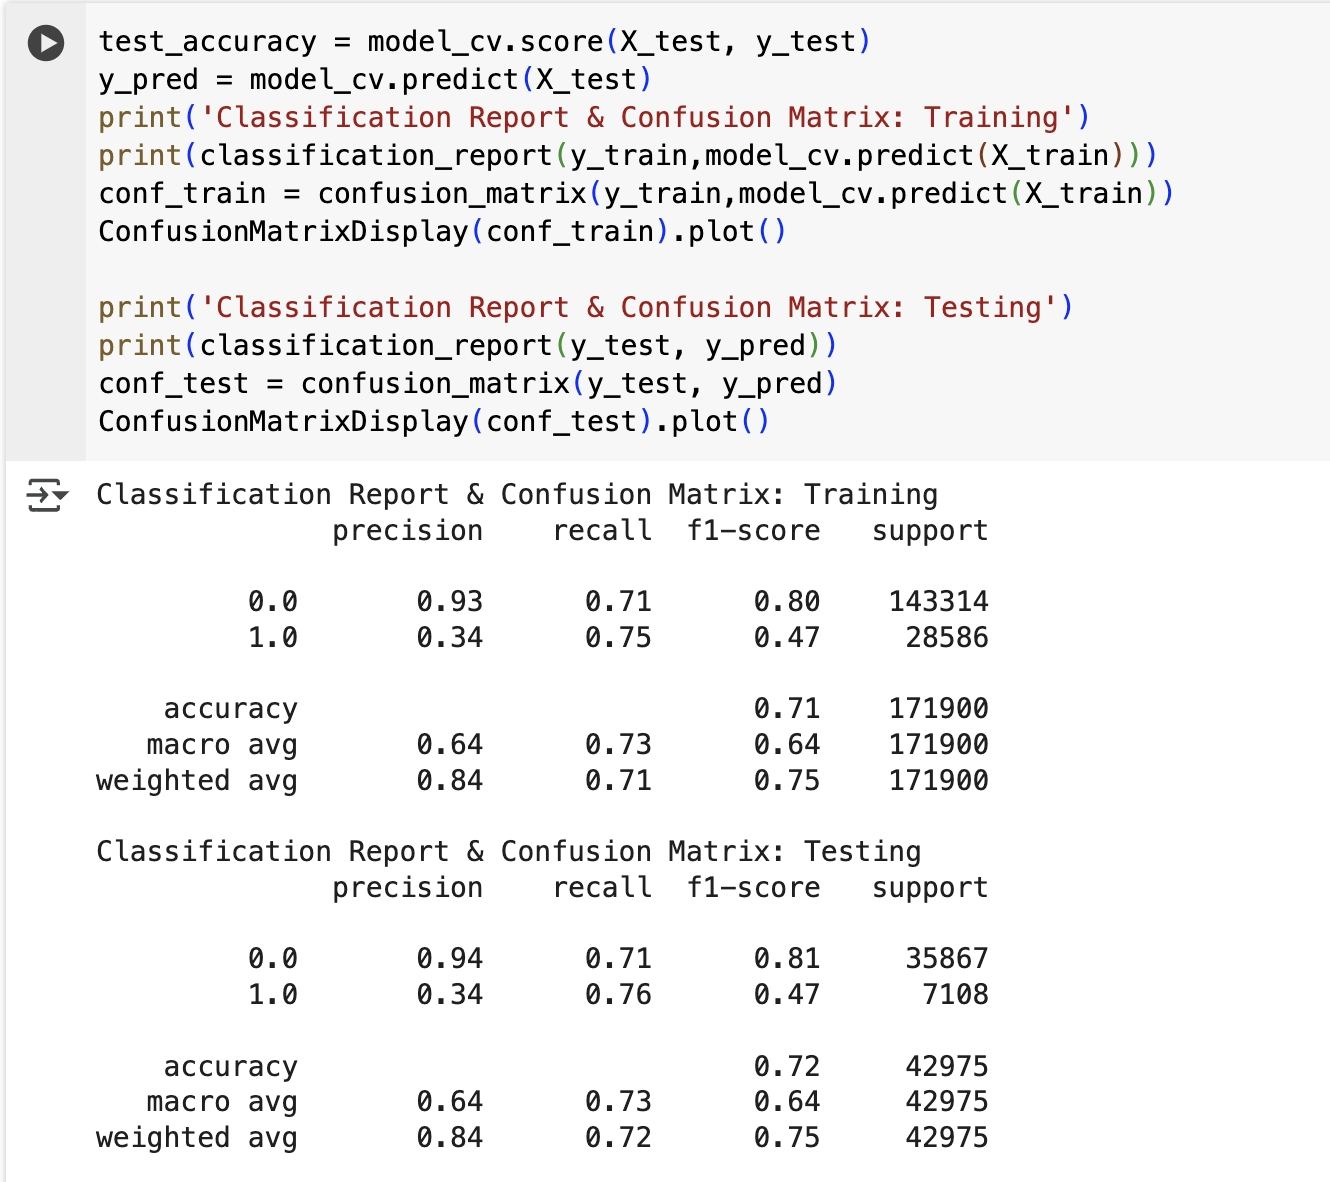
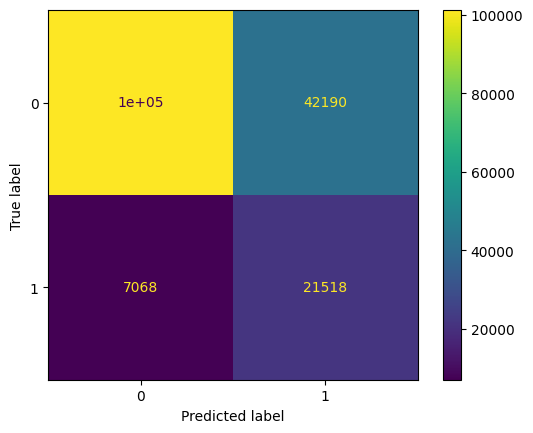

In [ ]:

threshold = 0.0

# Find the coefficients for the best C
best_c_index = np.argmin(np.abs(Cs_path - best_C))
best_coefs = coefs[best_c_index]

zero_like_predictors = X_train.columns[np.abs(best_coefs) <= threshold]
print(f"Predictors with coefficient eqaul to {threshold} at best C:")
for predictor in zero_like_predictors:
    print(predictor)

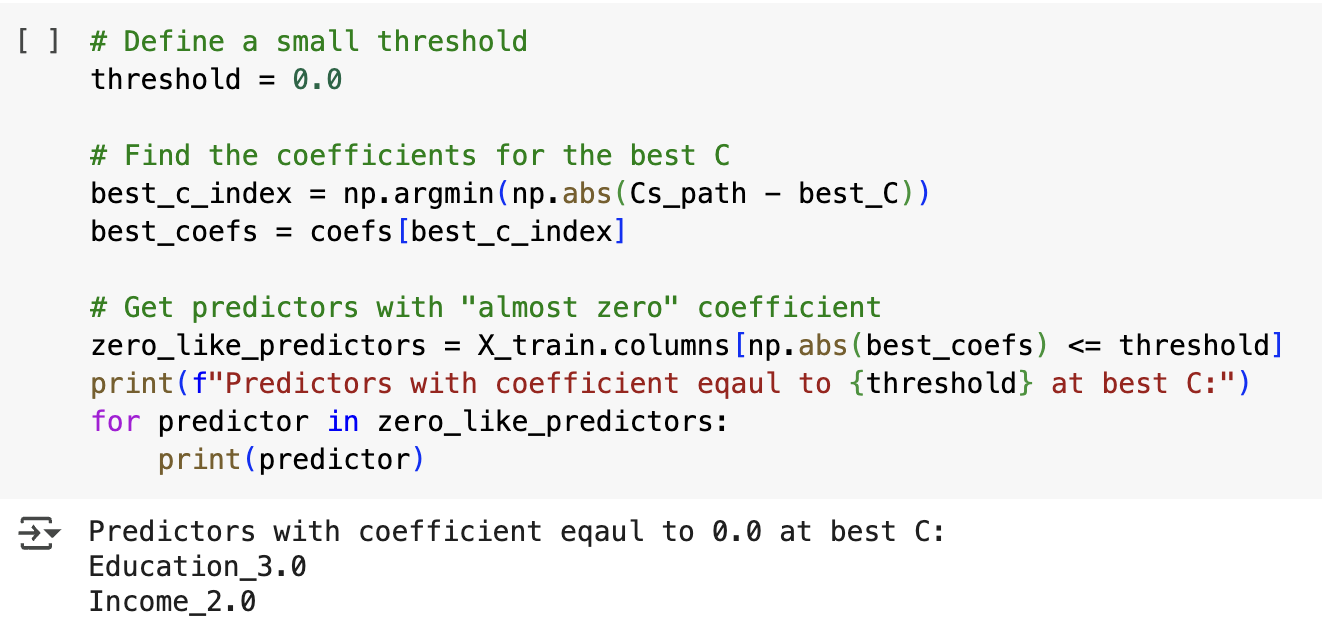

In [ ]:
print("Best predictors based on LASSO:")

best_predictors = []
for predictor,coef in zip(X_train.columns,best_coefs):
    if abs(coef) > 0.4:
      print(f"{predictor} : {coef}")
      best_predictors.append(predictor)

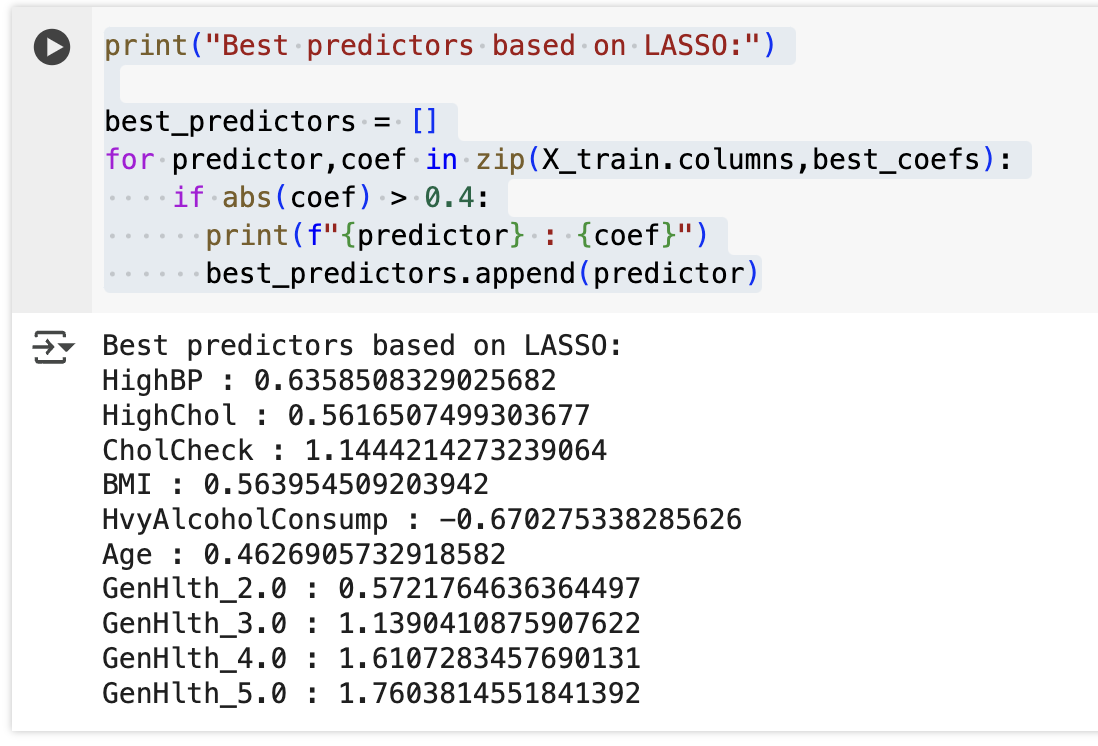

In [21]:
best_predictors = ['HighBP','HighChol','CholCheck','BMI','HvyAlcoholConsump','Age','GenHlth_2.0','GenHlth_3.0','GenHlth_4.0','GenHlth_5.0']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


X_train_rf = X_train
X_test_rf = X_test
y_train_rf = y_train
y_test_rf = y_test

np.where(y_train_rf == 2,1)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=150,     # number of trees
    max_depth=11,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train_rf, y_train_rf)


# Evaluate
print("Random Forest Classification Report (Train):")
print(classification_report(y_train_rf, rf_model.predict(X_train_rf)))

print("Random Forest Classification Report (Test):")
print(classification_report(y_test_rf, rf_model.predict(X_test_rf)))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


y_scores = rf_model.predict_proba(X_test_rf)[:, 1]


fpr, tpr, thresholds = roc_curve(y_test_rf, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



Random Forest Classification Report (Train):
              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80    152043
         1.0       0.11      0.48      0.18      3703
         2.0       0.36      0.72      0.48     28078

    accuracy                           0.70    183824
   macro avg       0.47      0.63      0.49    183824
weighted avg       0.84      0.70      0.74    183824

Random Forest Classification Report (Test):
              precision    recall  f1-score   support

         0.0       0.93      0.70      0.80     38012
         1.0       0.03      0.13      0.05       926
         2.0       0.35      0.68      0.46      7019

    accuracy                           0.68     45957
   macro avg       0.44      0.50      0.44     45957
weighted avg       0.83      0.68      0.73     45957



ValueError: multiclass format is not supported

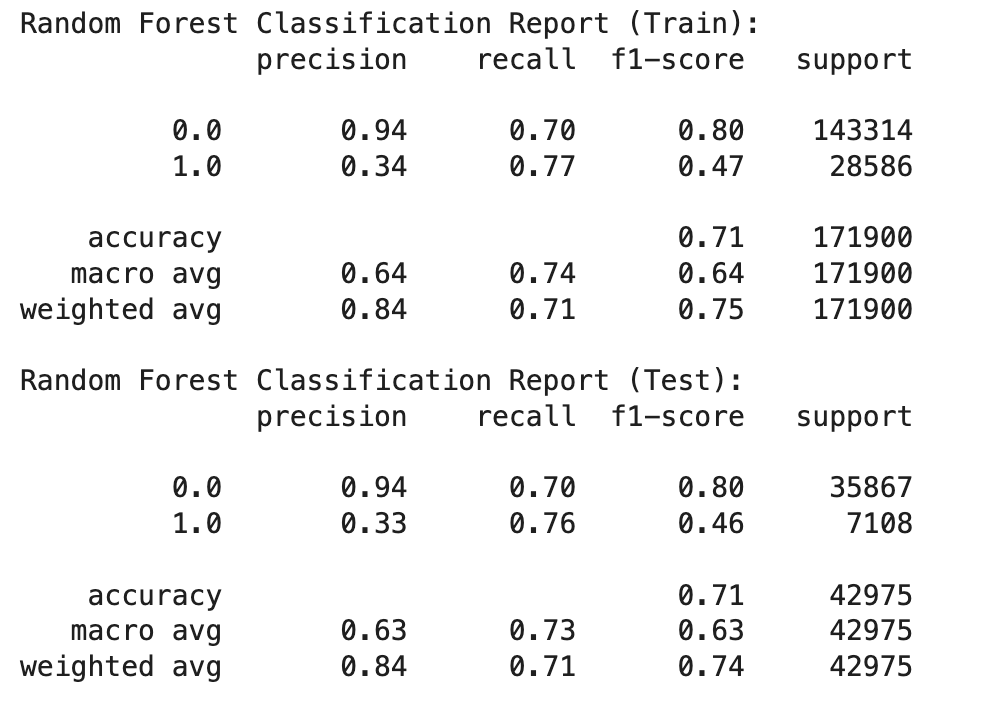
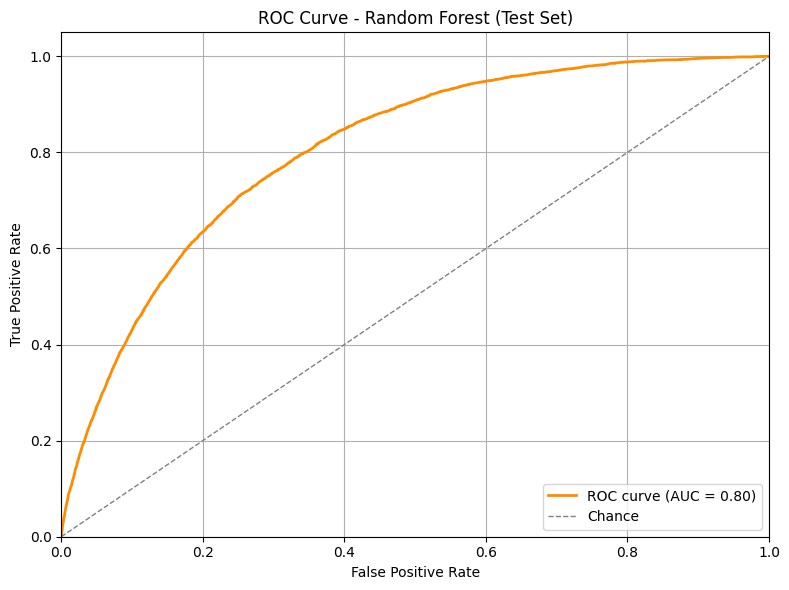

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.ticker as ticker
# Prepare data
X_train_rf = X_train[best_predictors + [target_col]]
X_test_rf = X_test[best_predictors + [target_col]]
y_train_rf = y_train
y_test_rf = y_test

# Depth values
depths = range(2, 22, 2)

# Store F1 scores
f1_class_0_train, f1_class_1_train = [], []
f1_class_0_test, f1_class_1_test = [], []

for depth in depths:
    rf_model = RandomForestClassifier(
        n_estimators=150,
        max_depth=depth,
        random_state=42,
        class_weight='balanced'
    )
    rf_model.fit(X_train_rf, y_train_rf)

    # Predictions
    y_train_pred = rf_model.predict(X_train_rf)
    y_test_pred = rf_model.predict(X_test_rf)

    # Classification reports
    report_train = classification_report(y_train_rf, y_train_pred, output_dict=True, zero_division=0)
    report_test = classification_report(y_test_rf, y_test_pred, output_dict=True, zero_division=0)

    # Append F1 scores
    f1_class_0_train.append(report_train.get('0.0', {}).get('f1-score', 0.0))
    f1_class_1_train.append(report_train.get('1.0', {}).get('f1-score', 0.0))
    f1_class_0_test.append(report_test.get('0.0', {}).get('f1-score', 0.0))
    f1_class_1_test.append(report_test.get('1.0', {}).get('f1-score', 0.0))

# Plot
plt.figure(figsize=(12, 6))
plt.xticks(np.arange(min(depths), max(depths) + 1, 1))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.plot(depths, f1_class_0_train, 'o--', label='Train F1 - Class 0')
plt.plot(depths, f1_class_1_train, 's--', label='Train F1 - Class 1')
plt.plot(depths, f1_class_0_test, 'o-', label='Test F1 - Class 0')
plt.plot(depths, f1_class_1_test, 's-', label='Test F1 - Class 1')


plt.xlabel('Tree Depth')
plt.ylabel('F1 Score')
plt.title('F1 Scores per Class vs Tree Depth (Train & Test) | 10 Best Predictors based on LASSO ')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


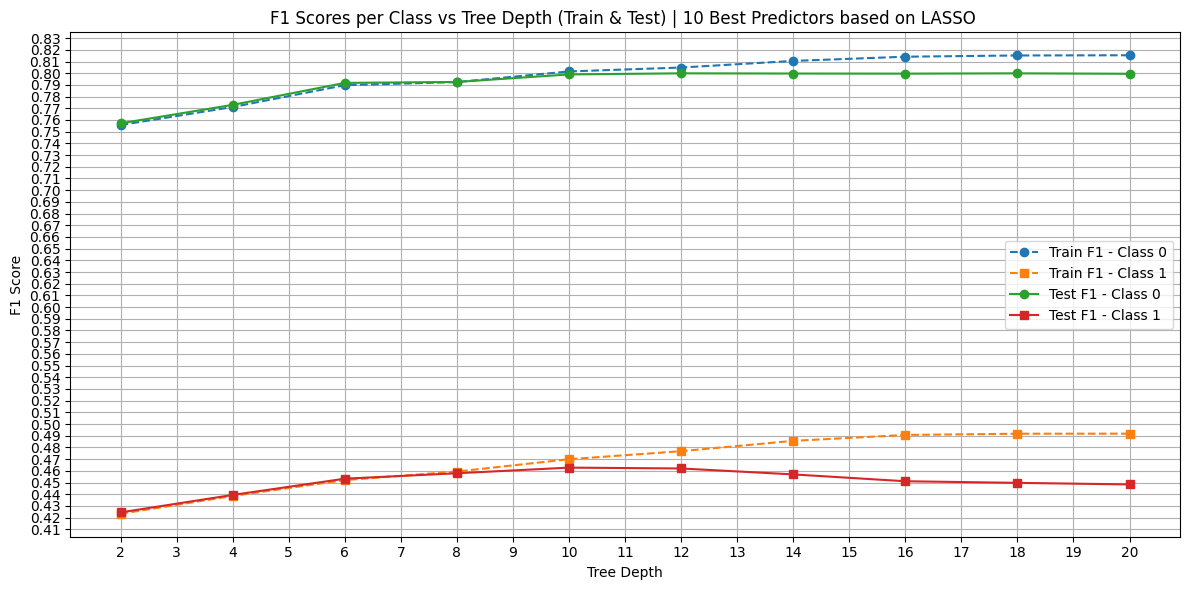

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train_rf = X_train
X_test_rf = X_test
y_train_rf = y_train
y_test_rf = y_test

# Depth values
depths = range(2, 22, 2)

# Store F1 scores
f1_class_0_train, f1_class_1_train = [], []
f1_class_0_test, f1_class_1_test = [], []

for depth in depths:
    rf_model = RandomForestClassifier(
        n_estimators=150,
        max_depth=depth,
        random_state=42,
        class_weight='balanced'
    )
    rf_model.fit(X_train_rf, y_train_rf)

    # Predictions
    y_train_pred = rf_model.predict(X_train_rf)
    y_test_pred = rf_model.predict(X_test_rf)

    # Classification reports
    report_train = classification_report(y_train_rf, y_train_pred, output_dict=True, zero_division=0)
    report_test = classification_report(y_test_rf, y_test_pred, output_dict=True, zero_division=0)

    # Append F1 scores
    f1_class_0_train.append(report_train.get('0.0', {}).get('f1-score', 0.0))
    f1_class_1_train.append(report_train.get('1.0', {}).get('f1-score', 0.0))
    f1_class_0_test.append(report_test.get('0.0', {}).get('f1-score', 0.0))
    f1_class_1_test.append(report_test.get('1.0', {}).get('f1-score', 0.0))

# Plot
plt.figure(figsize=(12, 8))

plt.xticks(np.arange(min(depths), max(depths) + 1, 1))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.plot(depths, f1_class_0_train, 'o--', label='Train F1 - Class 0')
plt.plot(depths, f1_class_1_train, 's--', label='Train F1 - Class 1')
plt.plot(depths, f1_class_0_test, 'o-', label='Test F1 - Class 0')
plt.plot(depths, f1_class_1_test, 's-', label='Test F1 - Class 1')

plt.xlabel('Tree Depth')
plt.ylabel('F1 Score')
plt.title('F1 Scores per Class vs Tree Depth (Train & Test)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


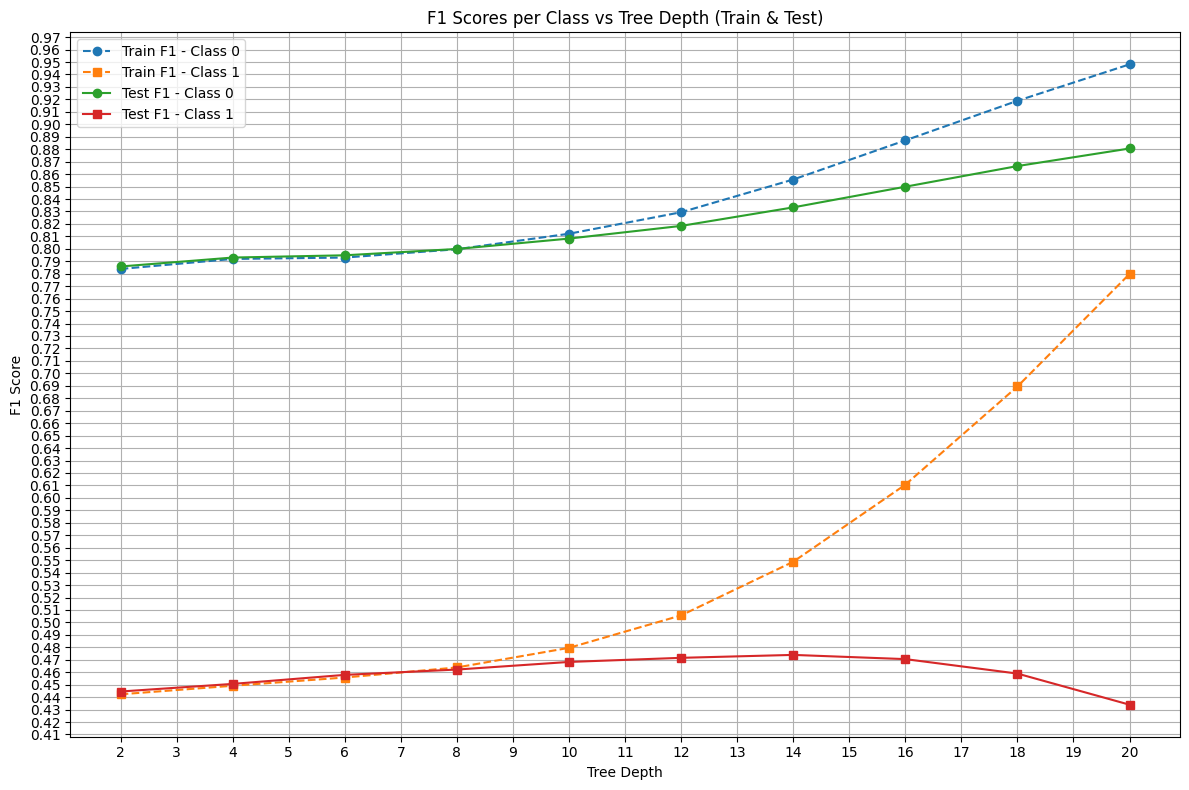

Confusion Matrix (Test):
[[26516  2881  8615]
 [  331   117   478]
 [ 1546   672  4801]]

Classification Report (Test):
              precision    recall  f1-score   support

         0.0       0.93      0.70      0.80     38012
         1.0       0.03      0.13      0.05       926
         2.0       0.35      0.68      0.46      7019

    accuracy                           0.68     45957
   macro avg       0.44      0.50      0.44     45957
weighted avg       0.83      0.68      0.73     45957


Classification Report (Train):
              precision    recall  f1-score   support

         0.0       0.94      0.70      0.80    152043
         1.0       0.11      0.48      0.18      3703
         2.0       0.36      0.72      0.48     28078

    accuracy                           0.70    183824
   macro avg       0.47      0.63      0.49    183824
weighted avg       0.84      0.70      0.74    183824



/var/folders/ct/gz2l61m13y595l77djnpfg480000gn/T/ipykernel_36216/3344054745.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


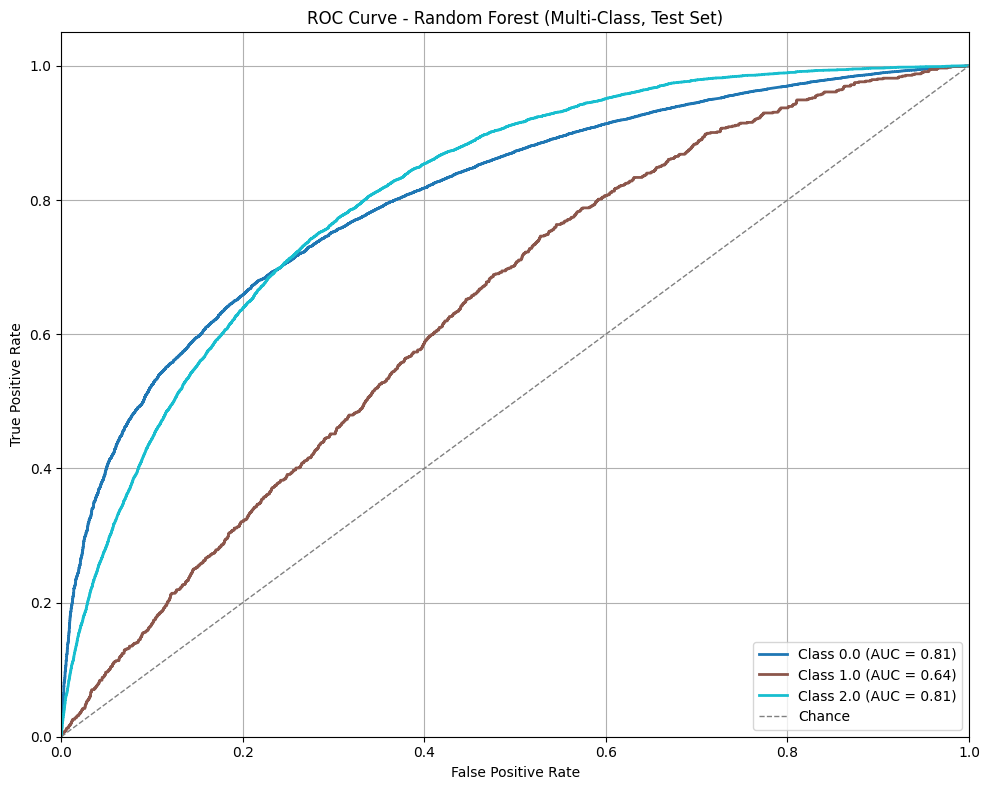

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# --- Train the model ---
rf_model = RandomForestClassifier(
    n_estimators=150,
    max_depth=11,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)

# --- Predictions ---
y_pred_train = rf_model.predict(X_train)
y_pred_test = rf_model.predict(X_test)

# --- Evaluation ---
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred_test))
print("\nClassification Report (Train):")
print(classification_report(y_train, rf_model.predict(X_train)))
# --- ROC Curve for all classes ---
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = rf_model.predict_proba(X_test)
n_classes = len(classes)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# --- Plot ROC Curve for all classes ---
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {classes[i]} (AUC = {roc_auc[i]:.2f})", color=colors(i))

plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (Multi-Class, Test Set)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


=== [Binary Classification: 0 vs (1+2)] ===
Confusion Matrix:
[[27655 10357]
 [ 2112  5833]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82     38012
           1       0.36      0.73      0.48      7945

    accuracy                           0.73     45957
   macro avg       0.64      0.73      0.65     45957
weighted avg       0.83      0.73      0.76     45957



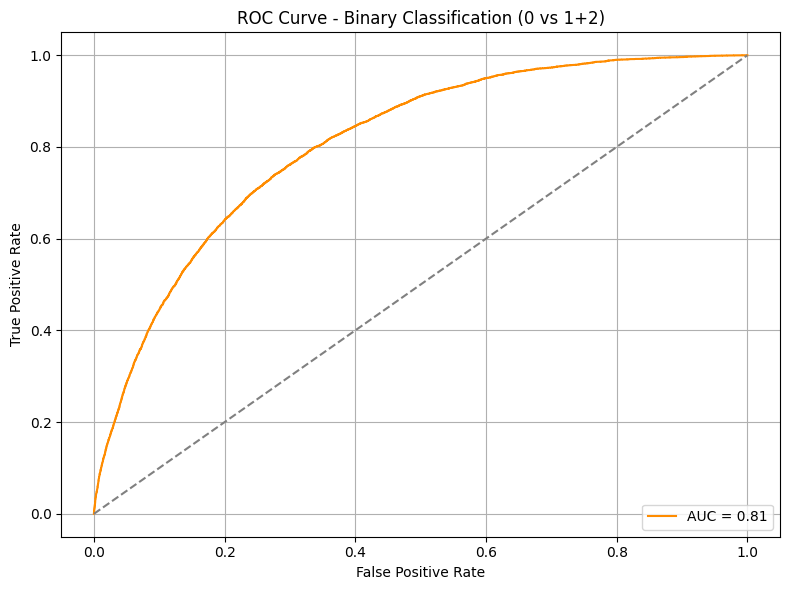


=== [Multi-Class Classification: 1 vs 2 only] ===
Confusion Matrix:
[[ 304  622]
 [1400 5620]]

Classification Report:
              precision    recall  f1-score   support

         1.0       0.18      0.33      0.23       926
         2.0       0.90      0.80      0.85      7020

    accuracy                           0.75      7946
   macro avg       0.54      0.56      0.54      7946
weighted avg       0.82      0.75      0.78      7946



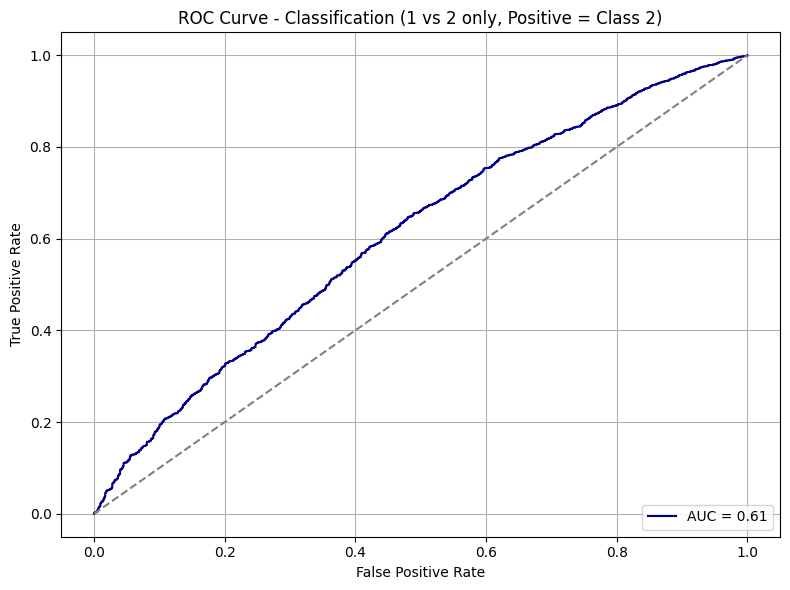

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

#Binary classification (0 vs 1+2) 

# Create binary labels: 0 stays 0, 1 and 2 become 1
y_binary = np.where(y == 0, 0, 1)

# Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X, y_binary, test_size=0.2, random_state=42, stratify=y_binary)

# Train Random Forest
rf_bin = RandomForestClassifier(n_estimators=150, max_depth=11, class_weight='balanced', random_state=42)
rf_bin.fit(X_train_bin, y_train_bin)

# Predict
y_pred_bin = rf_bin.predict(X_test_bin)
y_score_bin = rf_bin.predict_proba(X_test_bin)[:, 1]

# Evaluation
print("=== [Binary Classification: 0 vs (1+2)] ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test_bin, y_pred_bin))
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred_bin))

# ROC Curve
fpr_bin, tpr_bin, _ = roc_curve(y_test_bin, y_score_bin)
auc_bin = auc(fpr_bin, tpr_bin)

plt.figure(figsize=(8, 6))
plt.plot(fpr_bin, tpr_bin, label=f"AUC = {auc_bin:.2f}", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Binary Classification (0 vs 1+2)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Filter only classes 1 and 2
mask_12 = (y == 1) | (y == 2)
X_12 = X[mask_12]
y_12 = y[mask_12]

# Split
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(X_12, y_12, test_size=0.2, random_state=42, stratify=y_12)

# Train
rf_12 = RandomForestClassifier(n_estimators=150, max_depth=11, class_weight='balanced', random_state=42)
rf_12.fit(X_train_12, y_train_12)

# Predict
y_pred_12 = rf_12.predict(X_test_12)
y_score_12 = rf_12.predict_proba(X_test_12)

# Evaluation
print("\n=== [Multi-Class Classification: 1 vs 2 only] ===")
print("Confusion Matrix:")
print(confusion_matrix(y_test_12, y_pred_12))
print("\nClassification Report:")
print(classification_report(y_test_12, y_pred_12))


classes_12 = np.unique(y_12)

y_test_12_bin = (y_test_12 == 2).astype(int)
y_score_class2 = y_score_12[:, list(classes_12).index(2)]  # Probabilities for class 2

fpr_12, tpr_12, _ = roc_curve(y_test_12_bin, y_score_class2)
roc_auc_12 = auc(fpr_12, tpr_12)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_12, tpr_12, label=f"AUC = {roc_auc_12:.2f}", color='darkblue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve - Classification (1 vs 2 only, Positive = Class 2)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
